In [23]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from PIL import Image

import pandas as pd

import torch

from implementations.experimental_neural_nets import Conv_test, Road_data

from implementations.functions import *
from implementations.preprocessing import *
from implementations.mask_to_submission import masks_to_submission


from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score, f1_score, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import linear_model



### <b> Loading the data and preprocessing </b>

In [9]:

imgs, gt_imgs, test_imgs = getting_datasets()
print (len(imgs), len(gt_imgs), len(test_imgs))
print (test_imgs[0].shape)

imgs, gt_imgs = rotate_train_data(imgs, gt_imgs) 
imgs, gt_imgs = flip_train_data(imgs, gt_imgs) 


Loading X_train 100 images
Loading Y_train100 images
Loading X_test50 images
100 100 50
(608, 608, 3)
Number of images:  400
Number of groundtruth images:  400
Number of images after flipping:  1600
Number of groundtruth images after flipping:  1600


### <b> Example image loading with groundtruth </b>

Image size = 400,400


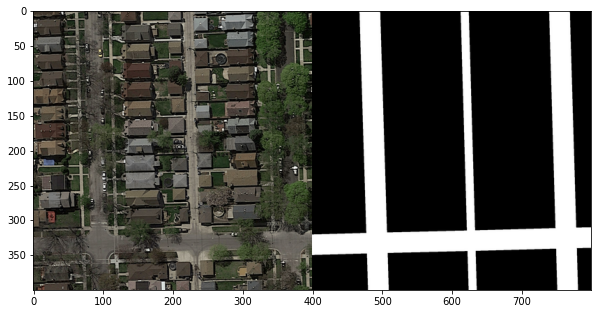

In [10]:
index=1000 
print("Image size = " + str(imgs[index].shape[0]) + "," + str(imgs[index].shape[1]))

cimg = concatenate_images(imgs[index], gt_imgs[index])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap="Greys_r")

### <b> Extract patches from input images and linearize them </b>


In [11]:
patch_size = 16  
n=len(imgs)
img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]
test_patches = [img_crop(test_imgs[i], patch_size, patch_size) for i in range(len(test_imgs))]

print("there are (400/16 = 25) x (400/16 = 25) = ", len(img_patches[0]), " patches per image for the training set")
print("there are (608/16 = 38) x (608/16 = 38) = ", len(test_patches[0]), " patches per image for the test set")


img_patches = np.asarray(
    [
        img_patches[i][j]  
        for i in range(len(img_patches)) 
        for j in range(len(img_patches[i]))  
    ]
)
gt_patches = np.asarray(
    [
        gt_patches[i][j]
        for i in range(len(gt_patches))
        for j in range(len(gt_patches[i]))
    ]
)

test_patches = np.asarray(
    [
        test_patches[i][j]
        for i in range(len(test_patches))
        for j in range(len(test_patches[i]))
    ]
)

there are (400/16 = 25) x (400/16 = 25) =  625  patches per image for the training set
there are (608/16 = 38) x (608/16 = 38) =  1444  patches per image for the test set


### <b> Extract 6-dimensional features consisting of average RGB color as well as variance </b>


In [12]:
def extract_features(img):
    feat_m = np.mean(img, axis=(0, 1)) 
    feat_v = np.var(img, axis=(0, 1)) 
    feat = np.append(feat_m, feat_v)
    return feat 


def extract_features_2d(img):
    feat_m = np.mean(img)
    feat_v = np.var(img)
    feat = np.append(feat_m, feat_v)
    return feat


def extract_img_features(filename):
    img = load_image(filename)
    img_patches = img_crop(img, patch_size, patch_size) 
    n_patches = len(img_patches) 
    X = np.zeros((n_patches, 6)) 
    
    for i in range(n_patches):
        X[i] = extract_features(img_patches[i])
    return X

In [13]:

def value_to_class(v, threshold):
    df = np.sum(v)
    if df > threshold:
        return 1
    else:
        return 0

X = np.asarray([extract_features(img_patches[i]) for i in range(len(img_patches))]) 
y_t  = np.asarray([extract_features(test_patches[i]) for i in range(len(test_patches))]) 

### <b> Grid Search of best model and hyperparameters </b>

In [56]:


def gridsearch_binary_classification(X, gt_patches, scoring='accuracy', cv=5, random_state=42, foreground_thresholds=[0.2,0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]):
    """
    Perform grid search to find the best model for binary classification.

    Parameters:
    - X: Features (pd.DataFrame or np.array)
    - y: Target labels (pd.Series or np.array)
    - gt_patches
    - scoring: Scoring metric ('accuracy', 'f1', 'roc_auc')
    - cv: Number of cross-validation folds
    - random_state: Random seed for reproducibility
    - foreground_thresholds: List of possible foreground thresholds to try

    Returns:
    - best_model: Best model after grid search
    - best_params: Best hyperparameters for the best model
    - best_threshold: Best foreground threshold
    - results: Grid search results
    """
    
    models = {
        'LogisticRegression': {
            'model': LogisticRegression(random_state=random_state, max_iter=1000),
            'params': {
                'C': [0.1, 1, 10],
                'solver': ['liblinear', 'lbfgs']
            }
        },
        'DecisionTree': {
            'model': DecisionTreeClassifier(random_state=random_state),
            'params': {
                'criterion': ['gini', 'entropy'],
                'max_depth': [None, 10, 20, 30],
                'min_samples_split': [2, 10, 20]
            }             
        },


        'RandomForest': {
            'model': RandomForestClassifier(random_state=random_state),
            'params': {
                'n_estimators': [50, 100, 200],
                'min_samples_split': [2, 5, 10],
                'max_depth': [None, 10, 20]
            }
        },

        'SVM': {
            'model': SVC(probability=True, random_state=random_state),
            'params': {
                'C': [0.1, 1, 10],
                'kernel': ['linear', 'rbf'],
                'gamma': ['scale', 'auto']
            }
        
       }
    }

    # Choose scoring metric
    scoring_metrics = {
        'accuracy': make_scorer(accuracy_score),
        'f1': make_scorer(f1_score),
        'roc_auc': make_scorer(roc_auc_score, needs_proba=True)
    }
    if scoring not in scoring_metrics:
        raise ValueError(f"Scoring must be one of {list(scoring_metrics.keys())}")
    
    scorer = scoring_metrics[scoring]

    # Perform grid search for each model
    best_model = None
    best_score = -float('inf')
    best_params = None
    best_threshold = None
    results = []

    for threshold in foreground_thresholds:
        print(f"Trying foreground threshold: {threshold}")
        
        Y = np.asarray([value_to_class(np.mean(gt_patches[i]), threshold) for i in range(len(gt_patches))])

        for name, config in models.items():
            print(f"Grid searching {name} with threshold {threshold}...")
            grid = GridSearchCV(estimator=config['model'],
                                param_grid=config['params'],
                                scoring=scorer,
                                cv=cv,
                                n_jobs=-1)
            grid.fit(X, Y)
            results.append({
                'model': name,
                'foreground_threshold': threshold,
                'best_score': grid.best_score_,
                'best_params': grid.best_params_
            })
            if grid.best_score_ > best_score:
                best_model = grid.best_estimator_
                best_score = grid.best_score_
                best_params = grid.best_params_
                best_threshold = threshold

    print("Best Model:", best_model)
    print("Best Parameters:", best_params)
    print("Best Foreground Threshold:", best_threshold)
    print("Best Score:", best_score)

    return best_model, best_params, best_threshold, results


In [57]:
best_model, best_params, best_threshold, results = gridsearch_binary_classification(X, gt_patches, scoring='accuracy', cv=5, random_state=42)

/Users/leonardotredici/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Trying foreground threshold: 0.2
Grid searching LogisticRegression with threshold 0.2...
Trying foreground threshold: 0.3
Grid searching LogisticRegression with threshold 0.3...
Trying foreground threshold: 0.4
Grid searching LogisticRegression with threshold 0.4...
Trying foreground threshold: 0.5
Grid searching LogisticRegression with threshold 0.5...
Trying foreground threshold: 0.6
Grid searching LogisticRegression with threshold 0.6...
Trying foreground threshold: 0.7
Grid searching LogisticRegression with threshold 0.7...
Trying foreground threshold: 0.8
Grid searching LogisticRegression with threshold 0.8...
Trying foreground threshold: 0.9
Grid searching LogisticRegression with threshold 0.9...
Best Model: LogisticRegression(C=0.1, max_iter=1000, random_state=42, solver='liblinear')
Best Parameters: {'C': 0.1, 'solver': 'liblinear'}
Best Foreground Threshold: 0.9
Best Score: 0.9085599999999999
Best model: LogisticRegression(C=0.1, max_iter=1000, random_state=42, solver='libline

### <b> Logistic regression as best model </b>

In [14]:


logreg_params = {
    'C': [0.1,10, 100, 1e5],  
    'solver': ['liblinear', 'lbfgs'], 
    'class_weight': ['balanced']  
}

Y = np.asarray([value_to_class(np.mean(gt_patches[i]), 0.45) for i in range(len(gt_patches))])

logreg = LogisticRegression(max_iter=100)

scorer = make_scorer(log_loss, needs_proba=True)

grid_search = GridSearchCV(estimator=logreg, param_grid=logreg_params, scoring=scorer, cv=5, n_jobs=-1)
grid_search.fit(X, Y)

best_logreg = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Logistic Regression Model:", best_logreg)
print("Best Parameters:", best_params)
print("Best log loss:", best_score)


/Users/leonardotredici/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Best Logistic Regression Model: LogisticRegression(C=10, class_weight='balanced')
Best Parameters: {'C': 10, 'class_weight': 'balanced', 'solver': 'lbfgs'}
Best log loss: 0.6567711507099852


### <b> train a logistic regression classifier </b>


In [15]:

logreg = best_logreg
logreg.fit(X, Y)

LogisticRegression(C=10, class_weight='balanced')

### <b> Predict on the training set </b>


In [16]:
print(X.shape)
Z = logreg.predict(X)

Zn = np.nonzero(Z)[0]
Yn = np.nonzero(Y)[0]

TPR = len(list(set(Yn) & set(Zn))) / float(len(Z))
print("True positive rate = " + str(TPR))

(1000000, 6)
True positive rate = 0.142752


### <b> Convert array of labels to an image </b>

In [17]:


def label_to_img(imgwidth, imgheight, w, h, labels):
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0, imgheight, h):
        for j in range(0, imgwidth, w):
            im[j : j + w, i : i + h] = labels[idx]
            idx = idx + 1
    return im


def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:, :, 0] = predicted_img * 255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, "RGB").convert("RGBA")
    overlay = Image.fromarray(color_mask, "RGB").convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img

### <b> Run prediction on the img_idx-th image </b>


In [18]:
img_idx = 0
image_dir =  "data/training/images/"
files = os.listdir(image_dir)
Xi = extract_img_features(image_dir + files[img_idx])
print(Xi.shape)
Zi = logreg.predict(Xi)

(625, 6)


### <b> Display prediction as an image </b>


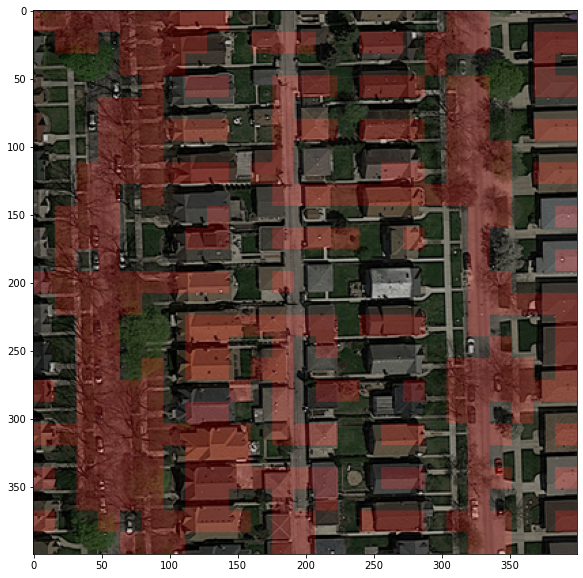

In [19]:

w = gt_imgs[img_idx].shape[0]
h = gt_imgs[img_idx].shape[1]

predicted_im = label_to_img(w, h, patch_size, patch_size, Zi)
cimg = concatenate_images(imgs[img_idx], predicted_im)
fig1 = plt.figure(figsize=(10, 10)) 
plt.imshow(cimg, cmap="Greys_r")

new_img = make_img_overlay(imgs[img_idx], predicted_im)

plt.imshow(new_img)

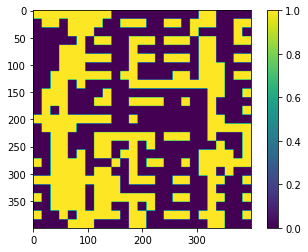

In [20]:
plt.imshow(predicted_im)
plt.colorbar()

### <b> Prediction on the test set </b>

(608, 608, 3)


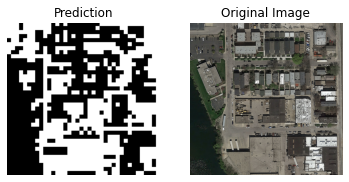

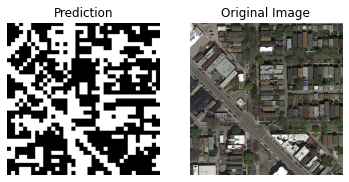

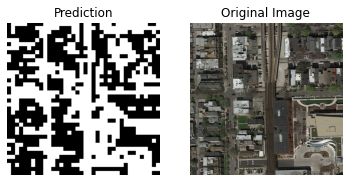

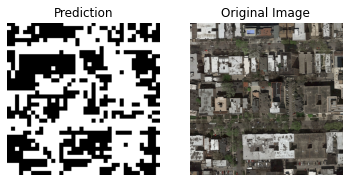

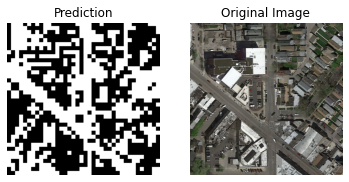

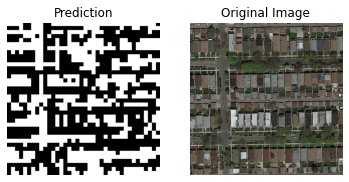

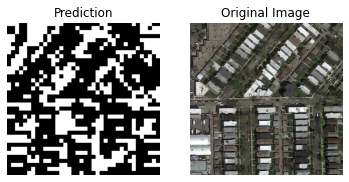

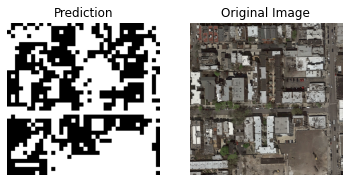

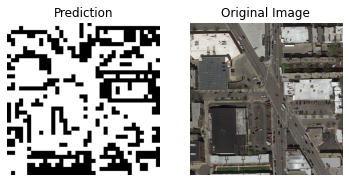

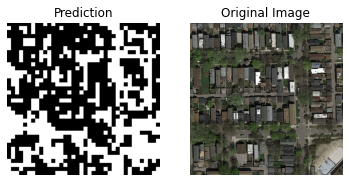

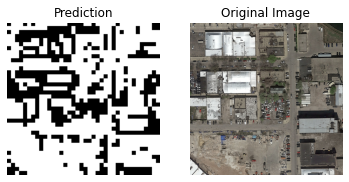

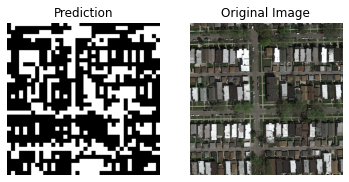

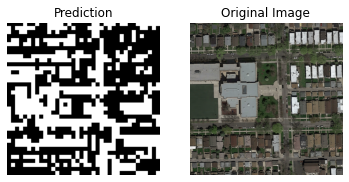

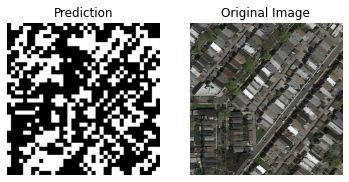

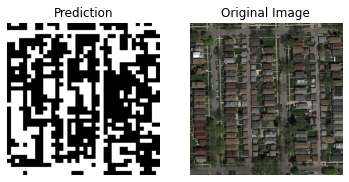

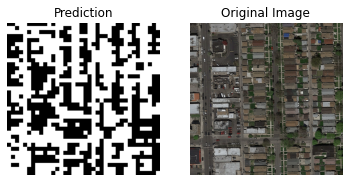

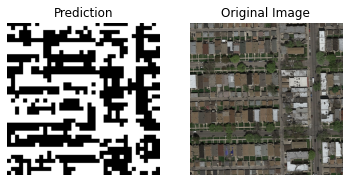

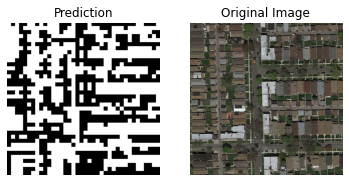

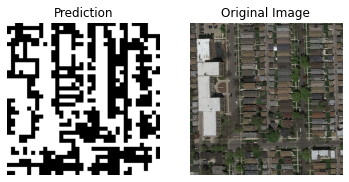

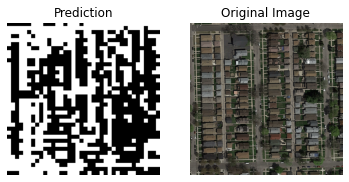

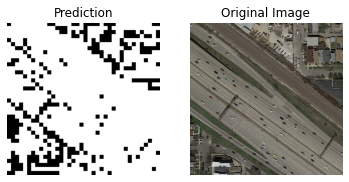

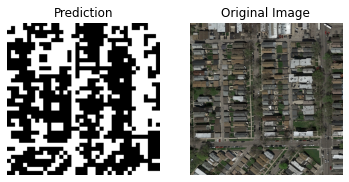

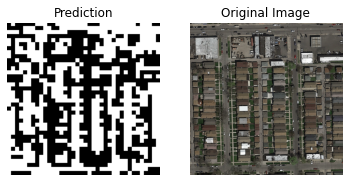

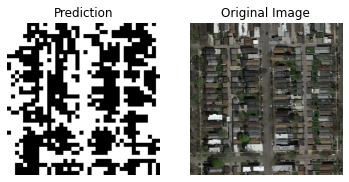

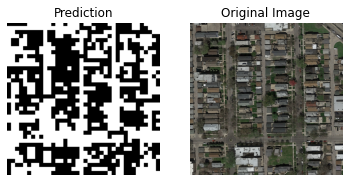

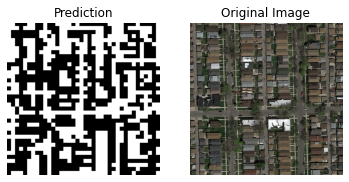

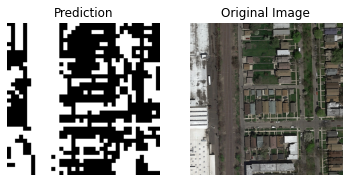

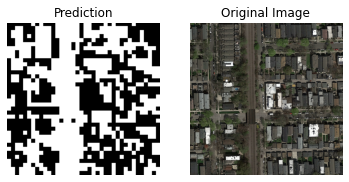

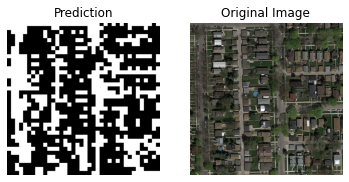

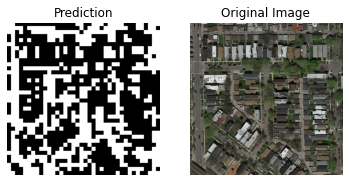

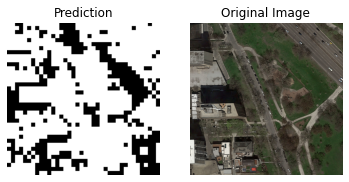

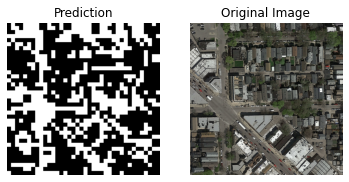

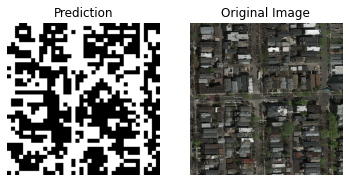

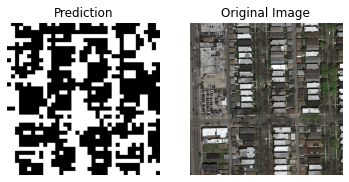

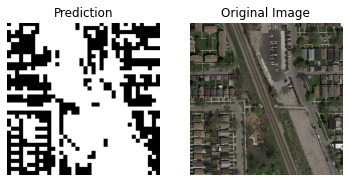

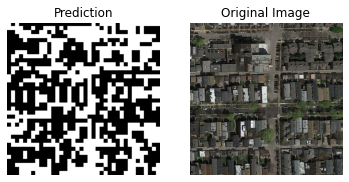

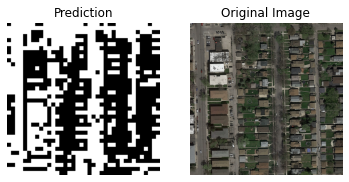

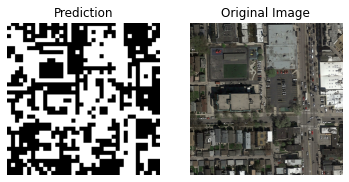

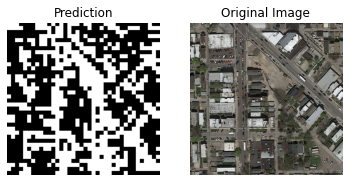

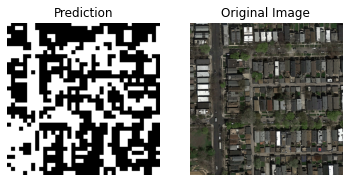

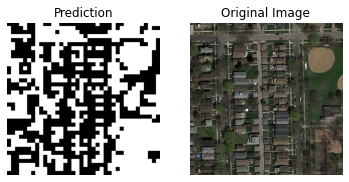

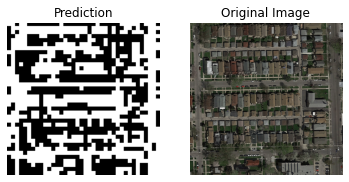

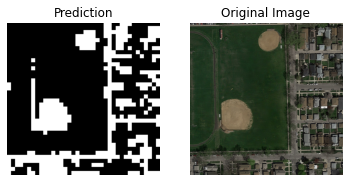

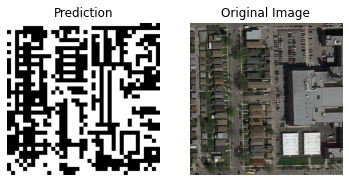

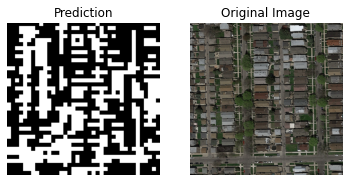

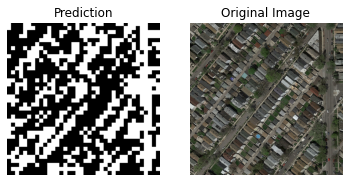

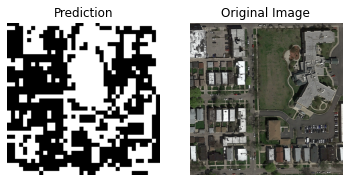

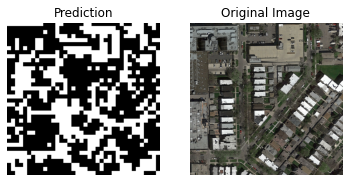

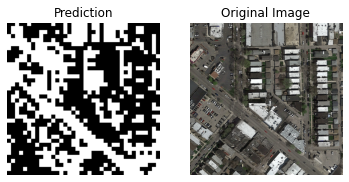

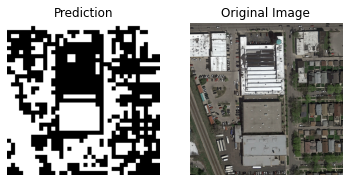

In [21]:
def get_predicted_img (test_imgs, model, y_t, patch_size=16): 
    """
        predict the image labels using the logistic model and return the predicted images
        
        Parameters:
        - test_imgs: list of test images
        - model: trained model to predict the labels of patches
        - y_t: features (shape: [total_patches, 6]) for all test image patches
        - patch_size: size of the patches
        
        Returns:
        - predicted_ims: list of predicted images based on the patches
        """
    predicted_ims = []
    predictions = (model.predict(y_t)) 
    start_index = 0  
    for i in range(len(test_imgs)):

        num_patches_per_img = (test_imgs[i].shape[0] // patch_size) * (test_imgs[i].shape[1] // patch_size) 
        end_index = start_index + num_patches_per_img
        img_predictions = predictions[start_index:end_index]
        # Convert the 1D prediction array to the original image grid using label_to_img
        predicted_img = label_to_img(test_imgs[i].shape[0], test_imgs[i].shape[1], patch_size, patch_size, img_predictions)
        predicted_ims.append(predicted_img)
        start_index = end_index 

    return predicted_ims


predicted_ims = get_predicted_img(test_imgs,logreg,y_t, patch_size=16)
print ((test_imgs[0].shape))

for i in range(len(test_imgs)):

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 6))
    
    axes[0].imshow(  predicted_ims[i], cmap='gray')
    axes[0].set_title("Prediction")
    
    axes[1].imshow(test_imgs[i])
    axes[1].set_title("Original Image")

    axes[0].axis("off")
    axes[1].axis("off")

    plt.show()

In [24]:


def getting_sub (prediction):
    output_dir = 'predictions_logistic'
    os.makedirs(output_dir, exist_ok=True)

    # Save each prediction as an image
    pred_filenames = []
    for i in range(len (prediction)):

        pred_image = Image.fromarray((prediction[i] * 255).astype(np.uint8), mode='L')     
        filename = os.path.join(output_dir, f"prediction_{i+1:03d}.png")
        pred_image.save(filename)
        pred_filenames.append(filename)

    # Now you can call the masks_to_submission function with the generated file paths
    submission_filename = 'logistic.csv'
    masks_to_submission(submission_filename, *pred_filenames)

getting_sub(predicted_ims)


